In [23]:
import numpy as np
import pandas as pd
import itertools
from sklearn import pipeline, model_selection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import log_loss
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

Set our parameters for xgboost
For Imbalanced dataset we set max_delta_step = 1

In [21]:
params = {}
class_names = ['Dislike','Like']
params['max_depth'] = [4,6,10]
params['max_delta_step'] = (1,3)
params['n_estimators'] = [100, 250, 500]
params['subsample'] =  [0.9, 1.0]
params['colsample_bytree']= [0.9, 1.0]
test_size = 0.20
random_seed = 42
label_encoder = LabelEncoder()

- Read the data
- Separate the labels
- Remove the unnecessary variables

In [3]:
dataset = pd.read_csv('../../../data/processed_data.csv')
labels = dataset[['like']]
data = dataset.drop(['Unnamed: 0','player_id','subject_id','like'],axis=1)

Encoding function for Categorical variables

In [4]:
def encode_features(df, encoder):
        columnsToEncode = list(df.select_dtypes(include=['category','object']))
        for feature in columnsToEncode:
            try:
                df[feature] = encoder.fit_transform(df[feature])
            except:
                print('Error encoding '+ feature)
        return df

Data Preparation:
- Encode categorical data
- Divide the data into training and test set

In [5]:
def data_prep():
    data_label_encoded = encode_features(data, label_encoder)
    X_train, X_test, y_train, y_test = train_test_split(data_label_encoded, labels, test_size=test_size, random_state=random_seed)
    return X_train, X_test, y_train, y_test

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
X_train, X_test, y_train, y_test = data_prep()

In [7]:
X_train.shape

(400610, 29)

Initialize the XGBClassifier model

In [8]:
xgb_model = XGBClassifier( learning_rate=0.1, 
                                        min_child_weight=1, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=random_seed)

Run grid search

In [9]:
grid_search = model_selection.GridSearchCV(estimator = xgb_model , 
                       param_grid = params, scoring='f1_weighted',n_jobs=4, cv=5)
grid_search.fit(X_train,y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'max_depth': [4, 6, 10], 'max_delta_step': (1, 3), 'n_estimators': [100, 250, 500], 'subsample': [0.9, 1.0], 'colsample_bytree': [0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_weighted', verbose=0)

In [11]:
grid_search.best_params_, grid_search.best_score_

({'colsample_bytree': 1.0,
  'max_delta_step': 1,
  'max_depth': 6,
  'n_estimators': 500,
  'subsample': 0.9},
 0.87813044437710386)

In [14]:
with open('../models/xgboost.pkl', "wb") as fp:
    pickle.dump(grid_search, fp)

In [18]:
y_scores = grid_search.best_estimator_.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
print(auc(y_test, y_scores, reorder=True))
print(auc(precision, recall, reorder=True))
y_predict = grid_search.best_estimator_.predict(X_test)
confusion_matrix_pca_logistic = confusion_matrix(y_test, y_predict)

0.49781063199
0.54580707681


Confusion matrix, without normalization
[[79035  3418]
 [ 8170  9530]]


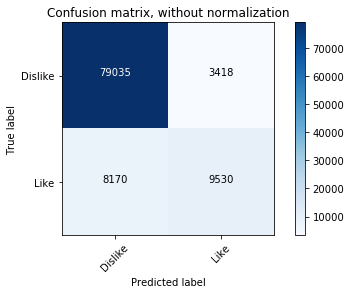

In [25]:
plt.figure()
plot_confusion_matrix(confusion_matrix_pca_logistic, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

In [37]:
feat_imp = pd.Series(grid_search.best_estimator_.get_booster().get_fscore()).sort_values(ascending=False)

In [38]:
feat_imp

subject_rated                 2488
subject_saved                 2390
distance                      2326
likes_ratio                   2006
player_rated                  1849
subject_location              1276
player_saved                  1243
subject_hometown              1155
player_location                974
subject_height                 912
player_hometown                855
player_height                  758
subject_age                    756
subject_age_max                700
player_age_max                 691
player_age                     670
subject_distance_max           657
player_distance_max            607
player_age_min                 602
subject_age_min                534
player_gender_orientation      212
subject_gender_orientation     190
subject_metro                  158
subject_height_min             153
player_height_min              153
player_height_max              148
subject_height_max             107
ratio                           78
player_metro        

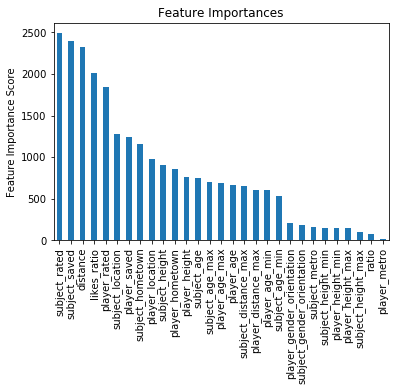

In [40]:
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

In [41]:
grid_search.predict_proba(X_test)[:,1]

array([ 0.00623622,  0.06155663,  0.077751  , ...,  0.00651608,
        0.00466726,  0.02592188], dtype=float32)